# Deep Learning: Sentiment Analysis

- In this unit, we will build a deep-learning-based sentiment classifier on the movie reviews from `ntlk`.

![](../images/keras-workflow.png)

:::{contents}
:::

## Prepare Data

In [1]:
import numpy as np
import nltk
from nltk.corpus import movie_reviews
import random

In [2]:
## Colab Only
nltk.download('movie_reviews')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents = [(text, 1) if label == "pos" else (text, 0)
             for (text, label) in documents]

random.shuffle(documents)

In [3]:
documents[1]

('there is nothing like american history x in theaters or on video . no other feature film takes such a cold hard look at the lure , the culture , and the brotherhood of white supremacy . nice guy ed norton jr . ( who sang in everyone says i love you ) plays derek , a twenty - year old skinhead . dad \' s subtle racism grew large in derek , after gang members killed his father . dad was fighting a fire when they shot him . now derek keeps his head shaved and has a giant swastika tattooed over his heart . derek is more interested in the ideas of white supremacy than in its culture of violence . at a basketball court , black and white tempers flare . derek channels the aggression into a game , black versus white , for ownership of the courts . when the choice presents itself , derek goes for game point instead of the sucker - punch . cameron ( stacy keach ) steps in to derek \' s life as a surrogate father . he takes derek under his wing and nurtures his racist feelings . keeping his own

## Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(documents,
                                       test_size=0.1,
                                       random_state=42)
print(len(train_set), len(test_set))

1800 200


## Prepare Input and Output Tensors

- For text vectorization, we will implement two alternatives:
    - Texts to Matrix: **One-hot encoding** of texts (similar to bag-of-words model)
    - Texts to Sequences: **Integer encoding** of all word tokens in texts and we will learn token **embeddings** along with the networks

- Important Steps:
    - Split data into **X** (texts) and **y** (sentiment labels)
    - Initialize `Tokenizer`
    - Use the `Tokenizer` for `text_to_sequences()` or `text_to_matrix()`
    - Padding the sequences to uniform lengths if needed (this can be either the max length of the sequences or any arbitrary length)
    

In [5]:
## Dependencies
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Bidirectional, Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import GlobalAveragePooling1D

In [8]:
## Split data into X (texts) and y (labels)
texts = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set]

In [9]:
print(len(texts))
print(len(labels))

1800
1800


### Tokenizer

- Important Notes:
    - We set the `num_words` at **10000**, meaning that the `Tokenizer` will automatically include only the most frequent **10000** words in the later text vectorization.
    - In other words, when we perform `text_to_sequences()` later, the `Tokenizer` will automatically remove words that are NOT in the top 10000 words.
    - However, the `tokenizer` still keeps the integer indices of all the words in the training texts (i.e., `tokenizer.word_index`)

In [10]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)

### Vocabulary

- When computing the vocabulary size, the plus 1 is due to the addition of the padding token.
- If `oov_token` is specified, then the vocabulary size needs to be added one more.
- When `oov_token` is specified, the unknown word tokens (i.e., words that are not in the top 10000 words) will be replaced with this `oov_token` token, instead of being removed from the texts.

In [11]:
# determine the vocabulary size
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 10001


In [12]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('a', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ("'", 6),
 ('is', 7),
 ('in', 8),
 ('s', 9),
 ('it', 10),
 ('that', 11),
 ('as', 12),
 ('with', 13),
 ('for', 14),
 ('this', 15),
 ('film', 16),
 ('his', 17),
 ('i', 18),
 ('he', 19),
 ('but', 20)]

In [13]:
len(tokenizer.word_index)

37775

## Define X and Y (Text Vectorization)

### Method 1: Text to Sequences

- Text to sequences (integers)
- Pad sequences

#### Text to Sequences

In [15]:
texts_ints = tokenizer.texts_to_sequences(texts)

In [16]:
print(len(texts[1000].split(' ')))  ## original text word number
print(len(texts_ints[1000]))  ## sequence token number

514
425


#### Padding

- When dealing with texts and documents, padding each text to the **maximum length** may not be ideal.
- For example, for sentiment classification, it is usually the case that authors would more clearly reveal/highlight his/her sentiment at the end of the text.
- Therefore, we can specify an arbitrary `max_len` in padding the sequences to (a) reduce the risk of including too much noise in our model, and (b) speed up the training steps.

/Users/alvinchen/anaconda3/envs/python-notes/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


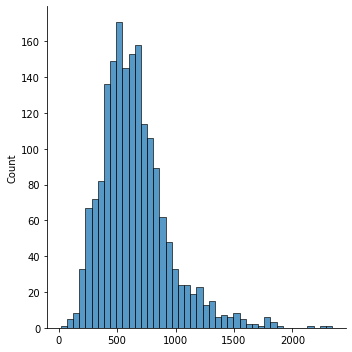

In [17]:
## Check the text len distribution
texts_lens = [len(n) for n in texts_ints]
texts_lens
import seaborn as sns
sns.displot(texts_lens)

In [19]:
## Find the maxlen of the texts
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2339

- In this tutorial, we consider only the **final** 400 tokens of each text, using the following parameters for `pad_sequences()`.
    - We keep the final 400 tokens from the text (`truncating='pre'`).
    - If the text is shorter than 400 tokens, we pad the text to 400 tokens at the beginning of the text (`padding='pre'`).

In [20]:
## Padding
max_len = 400
texts_ints_pad = sequence.pad_sequences(texts_ints,
                                        maxlen=max_len,
                                        truncating='pre',
                                        padding='pre')
texts_ints_pad[:10]

array([[1605, 3571, 1356, ...,    6,  118, 2143],
       [   0,    0,    0, ...,  310,   42, 2921],
       [  15, 2373,   69, ..., 1208,    3,  226],
       ...,
       [   0,    0,    0, ...,    8,  291,   10],
       [   1,   83, 2147, ...,   33,   39, 4910],
       [  40,   74,    7, ...,    6,    9, 9477]], dtype=int32)

In [21]:
## Gereate X and y for training
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)

## Gereate X and y for testing in the same way
X_test_texts = [n for (n, l) in test_set]
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                           maxlen=max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test_set])

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Method 2: Text to Matrix (One-hot Encoding/Bag-of-Words)

In [23]:
## Texts to One-Hot Encoding (bag of words)
texts_matrix = tokenizer.texts_to_matrix(texts, mode="binary")
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)

## Same for Testing Data
X_test2 = tokenizer.texts_to_matrix(X_test_texts,
                                    mode="binary").astype('int32')
y_test2 = np.array([l for (n, l) in test_set])

In [24]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


## Hyperparameters

In [25]:
## A few DL hyperparameters
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128

## Model Definition (Part 1)

In [27]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

### Model 1 (Feedforward Neural Network)

- Two layers of fully-connected dense layers
- The input is the one-hot encoding of the text from text-to-matrix.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.002.jpeg)

In [28]:
## Model 1
model1 = Sequential()
model1.add(Input(shape=(NUM_WORDS, )))
model1.add(Dense(16, activation="relu", name="dense_layer_1"))
model1.add(Dense(16, activation="relu", name="dense_layer_2"))
model1.add(Dense(1, activation="sigmoid", name="output"))

model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

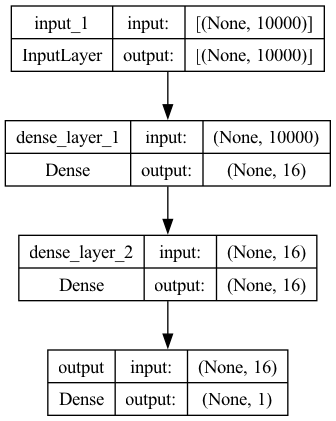

In [29]:
plot_model(model1, show_shapes=True)

In [26]:
history1 = model1.fit(X_train2,
                      y_train2,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6749 - accuracy: 0.6181 - val_loss: 0.6408 - val_accuracy: 0.6806 - 1s/epoch - 90ms/step
Epoch 2/25
12/12 - 0s - loss: 0.4979 - accuracy: 0.8785 - val_loss: 0.5114 - val_accuracy: 0.7750 - 95ms/epoch - 8ms/step
Epoch 3/25
12/12 - 0s - loss: 0.3008 - accuracy: 0.9479 - val_loss: 0.4198 - val_accuracy: 0.8278 - 95ms/epoch - 8ms/step
Epoch 4/25
12/12 - 0s - loss: 0.1666 - accuracy: 0.9771 - val_loss: 0.3618 - val_accuracy: 0.8361 - 93ms/epoch - 8ms/step
Epoch 5/25
12/12 - 0s - loss: 0.0858 - accuracy: 0.9979 - val_loss: 0.3312 - val_accuracy: 0.8444 - 95ms/epoch - 8ms/step
Epoch 6/25
12/12 - 0s - loss: 0.0455 - accuracy: 0.9993 - val_loss: 0.3209 - val_accuracy: 0.8389 - 90ms/epoch - 7ms/step
Epoch 7/25
12/12 - 0s - loss: 0.0265 - accuracy: 0.9993 - val_loss: 0.3210 - val_accuracy: 0.8528 - 90ms/epoch - 8ms/step
Epoch 8/25
12/12 - 0s - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.3176 - val_accuracy: 0.8500 - 89ms/epoch - 7ms/step
Epoch 9/25
12/12 - 0s - l

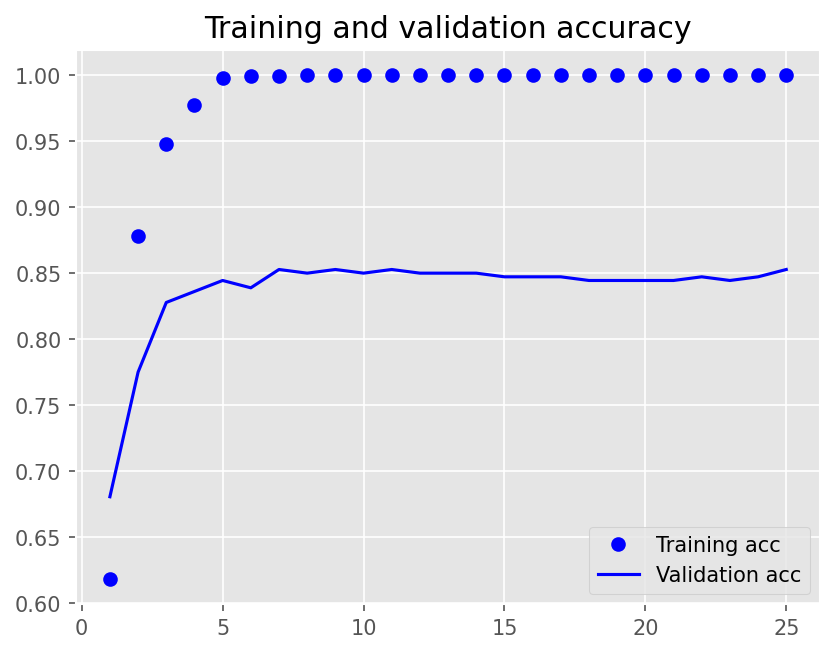

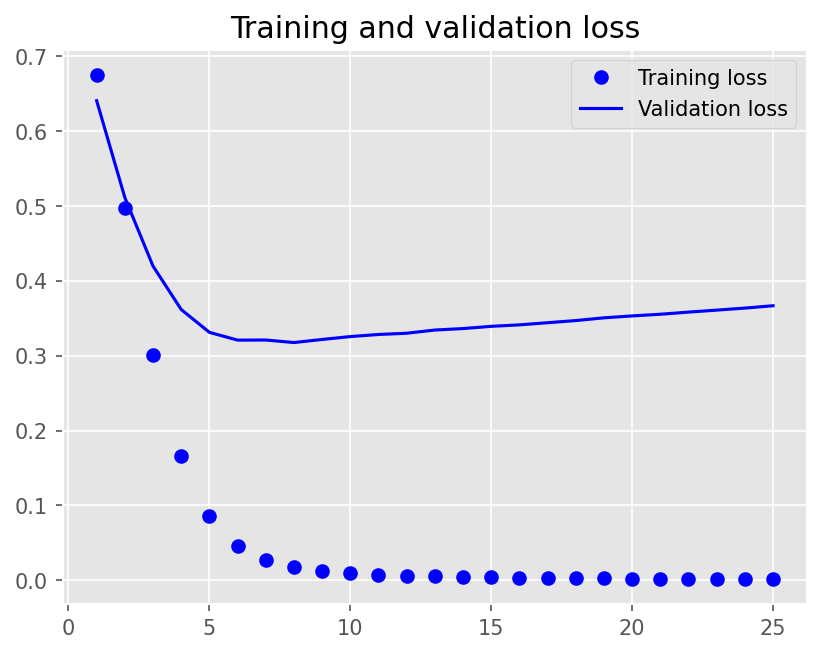

In [80]:
## Plot Training History
plot1(history1)

In [28]:
## Model Evaluation
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.2818 - accuracy: 0.9050 - 32ms/epoch - 16ms/step


[0.28181010484695435, 0.9049999713897705]

### Model 2 (Feedforward Neural Network)

- One Embedding Layer + Two fully-connected dense layers
- The Inputs are the sequences (integers) of texts.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.004.jpeg)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.008.jpeg)

In [30]:
## Model 2
model2 = Sequential()
model2.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model2.add(
    GlobalAveragePooling1D()
)  ## The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
model2.add(Dense(16, activation="relu", name="dense_layer_1"))
model2.add(Dense(16, activation="relu", name="dense_layer_2"))
model2.add(Dense(1, activation="sigmoid", name="output"))

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

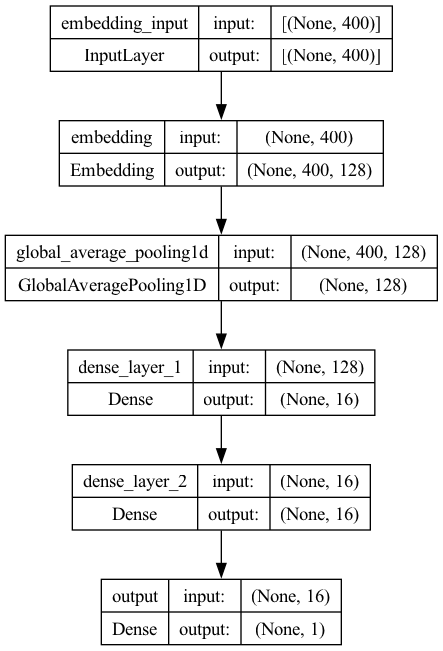

In [31]:
plot_model(model2, show_shapes=True)

In [31]:
history2 = model2.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6922 - accuracy: 0.5854 - val_loss: 0.6909 - val_accuracy: 0.6278 - 1s/epoch - 94ms/step
Epoch 2/25
12/12 - 0s - loss: 0.6863 - accuracy: 0.8104 - val_loss: 0.6857 - val_accuracy: 0.7278 - 207ms/epoch - 17ms/step
Epoch 3/25
12/12 - 0s - loss: 0.6764 - accuracy: 0.8222 - val_loss: 0.6762 - val_accuracy: 0.7333 - 197ms/epoch - 16ms/step
Epoch 4/25
12/12 - 0s - loss: 0.6600 - accuracy: 0.8722 - val_loss: 0.6641 - val_accuracy: 0.7639 - 198ms/epoch - 17ms/step
Epoch 5/25
12/12 - 0s - loss: 0.6332 - accuracy: 0.9097 - val_loss: 0.6422 - val_accuracy: 0.7556 - 208ms/epoch - 17ms/step
Epoch 6/25
12/12 - 0s - loss: 0.5925 - accuracy: 0.9215 - val_loss: 0.6136 - val_accuracy: 0.7667 - 196ms/epoch - 16ms/step
Epoch 7/25
12/12 - 0s - loss: 0.5337 - accuracy: 0.9444 - val_loss: 0.5741 - val_accuracy: 0.7806 - 190ms/epoch - 16ms/step
Epoch 8/25
12/12 - 0s - loss: 0.4593 - accuracy: 0.9528 - val_loss: 0.5312 - val_accuracy: 0.8028 - 196ms/epoch - 16ms/step
Epoch 9/25


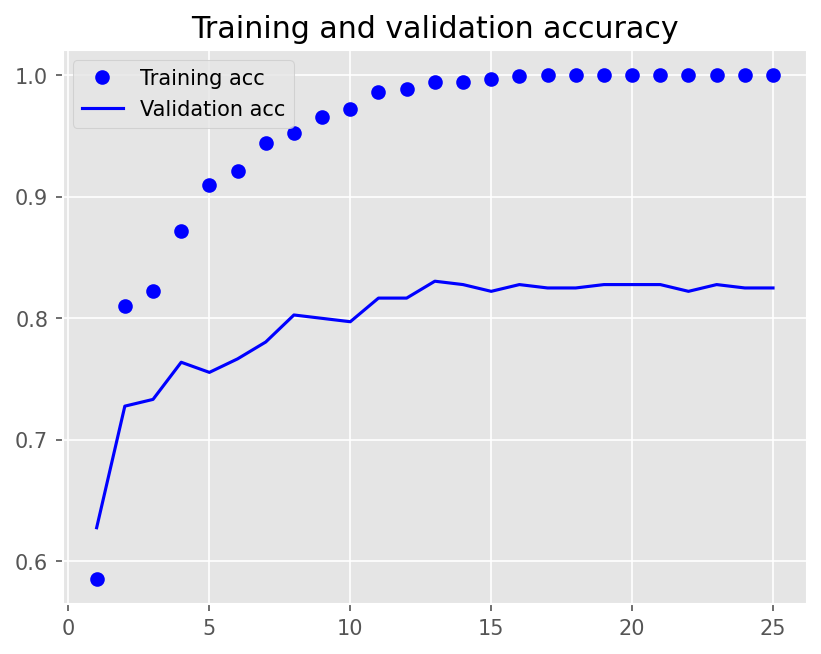

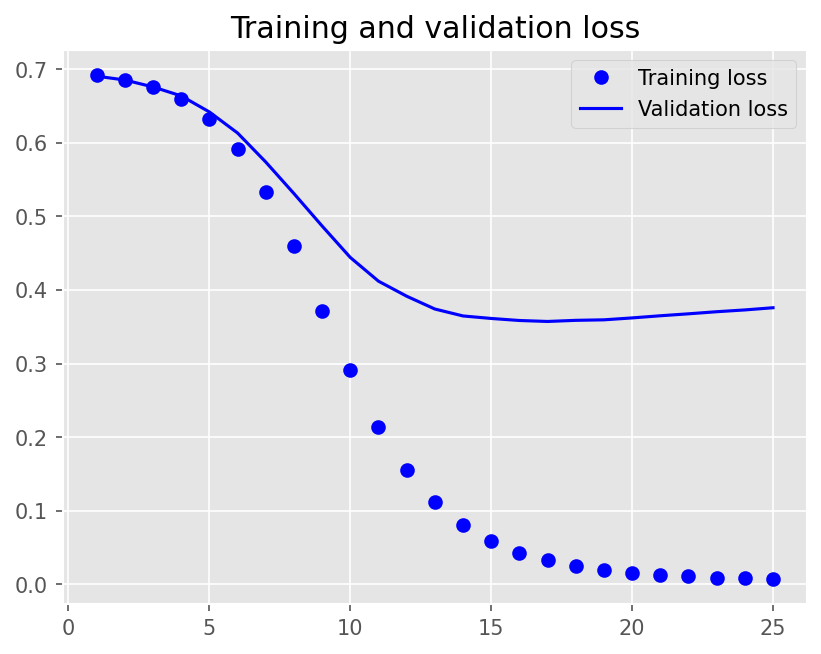

In [79]:
plot1(history2)

In [33]:
model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.3117 - accuracy: 0.8850 - 31ms/epoch - 16ms/step


[0.311745822429657, 0.8849999904632568]

:::{note}
**Issues of Word/Character Representations**
- Generally speaking, we can train our **word embeddings** along with the downstream NLP task (e.g., the sentiment classification in our current case).
- Another common method is to train the word embeddings using unsupervised methods on a large amount of data and apply the pre-trained word embeddings to the current downstream NLP task. Typical methods include word2vec (CBOW or skipped-gram, GloVe etc). We will come back to these unsupervised methods later.

:::

## Model Defintion (Part 2)

- For text sequences, we often apply RNN-based sequence models to create the model.

### Model 3 (LSTM)

- One Embedding Layer + LSTM + Dense Layer
- Input: the text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.012.jpeg)

In [32]:
## Model 3
model3 = Sequential()
model3.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

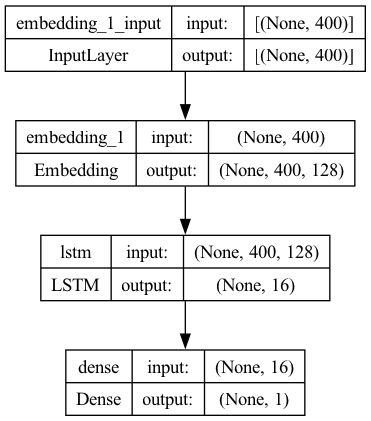

In [33]:
plot_model(model3, show_shapes=True)

In [36]:
history3 = model3.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6926 - accuracy: 0.5215 - val_loss: 0.6910 - val_accuracy: 0.5250 - 8s/epoch - 673ms/step
Epoch 2/25
12/12 - 4s - loss: 0.6809 - accuracy: 0.7181 - val_loss: 0.6886 - val_accuracy: 0.5500 - 4s/epoch - 351ms/step
Epoch 3/25
12/12 - 4s - loss: 0.6591 - accuracy: 0.7840 - val_loss: 0.6799 - val_accuracy: 0.5694 - 4s/epoch - 347ms/step
Epoch 4/25
12/12 - 4s - loss: 0.6036 - accuracy: 0.8125 - val_loss: 0.6592 - val_accuracy: 0.5861 - 4s/epoch - 342ms/step
Epoch 5/25
12/12 - 4s - loss: 0.4672 - accuracy: 0.8694 - val_loss: 0.5653 - val_accuracy: 0.7194 - 4s/epoch - 345ms/step
Epoch 6/25
12/12 - 4s - loss: 0.3663 - accuracy: 0.9153 - val_loss: 0.5579 - val_accuracy: 0.7361 - 4s/epoch - 342ms/step
Epoch 7/25
12/12 - 4s - loss: 0.3172 - accuracy: 0.9417 - val_loss: 0.6491 - val_accuracy: 0.6889 - 4s/epoch - 344ms/step
Epoch 8/25
12/12 - 4s - loss: 0.2537 - accuracy: 0.9528 - val_loss: 0.5189 - val_accuracy: 0.7639 - 4s/epoch - 340ms/step
Epoch 9/25
12/12 - 4s - 

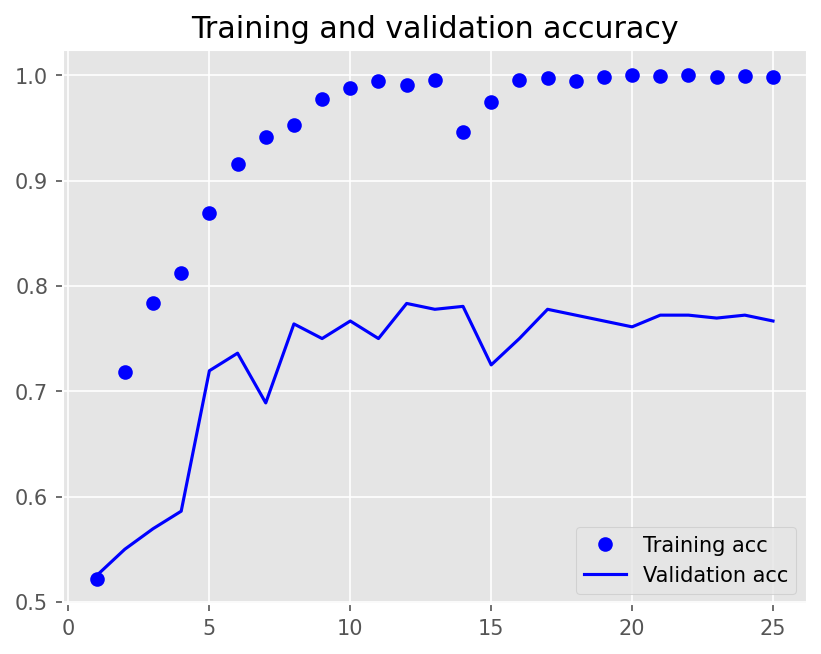

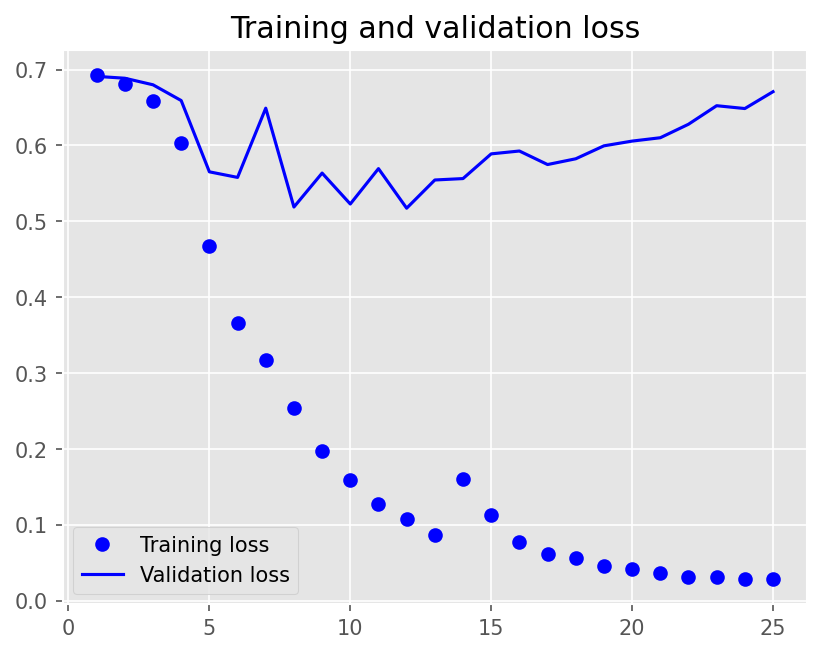

In [78]:
plot1(history3)

In [38]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.5916 - accuracy: 0.8250 - 134ms/epoch - 67ms/step


[0.5916371941566467, 0.824999988079071]

### Model 4 (Stacked LSTM)

- One Embedding Layer + Two Stacked LSTM + Dense Layer
- Inputs: text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.013.jpeg)

In [34]:
## Model 4
model4 = Sequential()
model4.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model4.add(LSTM(16,
                return_sequences=True, ## return hidden states of all time steps
                dropout=0.2,
                recurrent_dropout=0.2))
model4.add(LSTM(16,
                dropout=0.2,
                recurrent_dropout=0.2))
model4.add(Dense(1, activation="sigmoid"))

model4.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

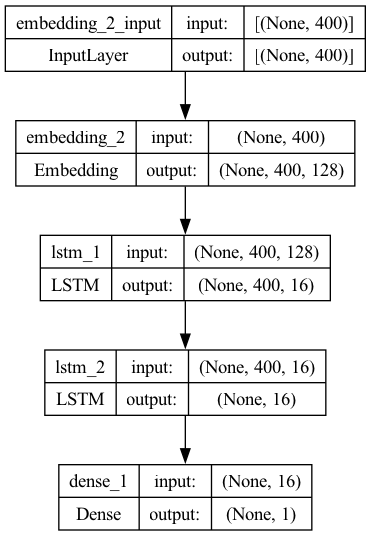

In [35]:
plot_model(model4, show_shapes=True)

In [41]:
history4 = model4.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
12/12 - 14s - loss: 0.6929 - accuracy: 0.5069 - val_loss: 0.6924 - val_accuracy: 0.5056 - 14s/epoch - 1s/step
Epoch 2/25
12/12 - 8s - loss: 0.6853 - accuracy: 0.6576 - val_loss: 0.6879 - val_accuracy: 0.5944 - 8s/epoch - 654ms/step
Epoch 3/25
12/12 - 8s - loss: 0.6574 - accuracy: 0.7667 - val_loss: 0.6704 - val_accuracy: 0.5833 - 8s/epoch - 675ms/step
Epoch 4/25
12/12 - 8s - loss: 0.5275 - accuracy: 0.8132 - val_loss: 0.6083 - val_accuracy: 0.6639 - 8s/epoch - 677ms/step
Epoch 5/25
12/12 - 8s - loss: 0.3515 - accuracy: 0.8813 - val_loss: 0.6018 - val_accuracy: 0.6972 - 8s/epoch - 666ms/step
Epoch 6/25
12/12 - 8s - loss: 0.2318 - accuracy: 0.9479 - val_loss: 0.6376 - val_accuracy: 0.7139 - 8s/epoch - 662ms/step
Epoch 7/25
12/12 - 8s - loss: 0.1455 - accuracy: 0.9757 - val_loss: 0.6665 - val_accuracy: 0.7361 - 8s/epoch - 660ms/step
Epoch 8/25
12/12 - 8s - loss: 0.0961 - accuracy: 0.9875 - val_loss: 0.6514 - val_accuracy: 0.7500 - 8s/epoch - 661ms/step
Epoch 9/25
12/12 - 8s - l

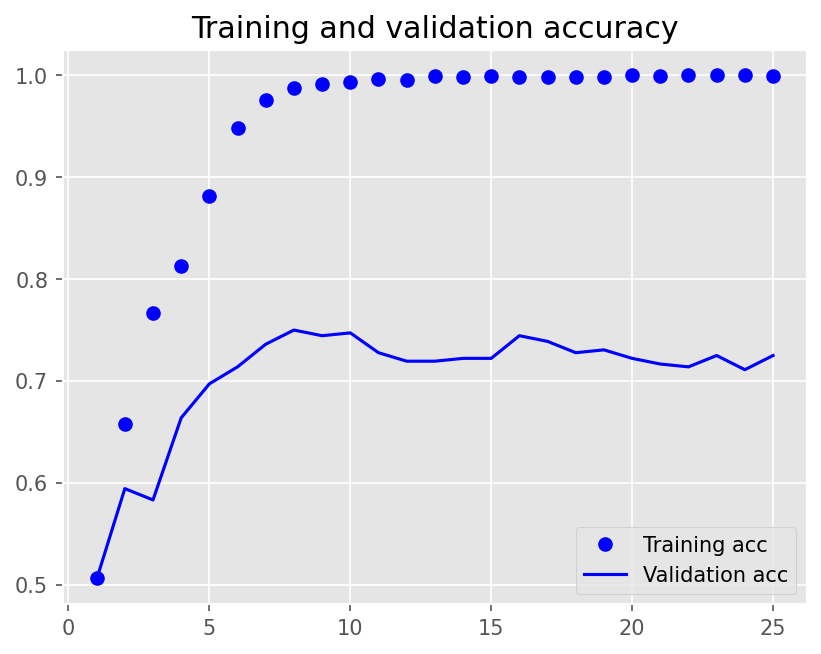

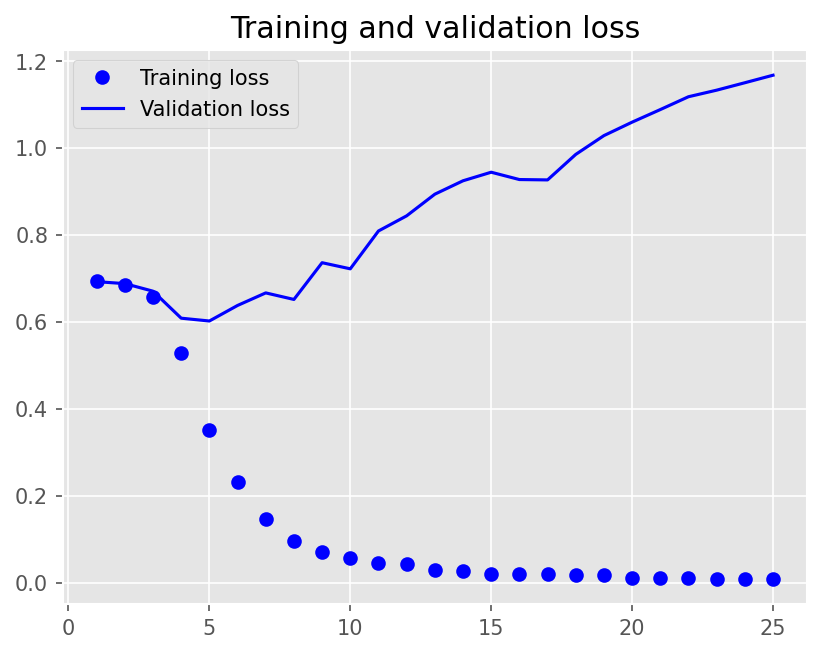

In [77]:
plot1(history4)

In [43]:
model4.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.2005 - accuracy: 0.6900 - 213ms/epoch - 107ms/step


[1.2005281448364258, 0.6899999976158142]

### Model 5 (Bidirectional LSTM)

- Embedding Layer + Bidirectional LSTM + Dense Layer
- Inputs: Text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.014.jpeg)

In [36]:
## Model 5
model5 = Sequential()
model5.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model5.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))
model5.add(Dense(1, activation="sigmoid"))

model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

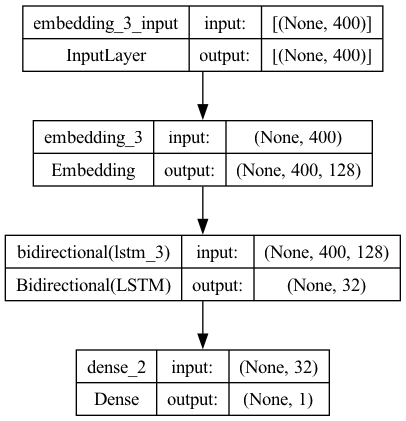

In [37]:
plot_model(model5, show_shapes=True)

In [46]:
history5 = model5.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
12/12 - 12s - loss: 0.6924 - accuracy: 0.5035 - val_loss: 0.6929 - val_accuracy: 0.4750 - 12s/epoch - 981ms/step
Epoch 2/25
12/12 - 5s - loss: 0.6743 - accuracy: 0.6750 - val_loss: 0.6883 - val_accuracy: 0.5250 - 5s/epoch - 417ms/step
Epoch 3/25
12/12 - 5s - loss: 0.6367 - accuracy: 0.7646 - val_loss: 0.6737 - val_accuracy: 0.5556 - 5s/epoch - 411ms/step
Epoch 4/25
12/12 - 5s - loss: 0.5168 - accuracy: 0.8576 - val_loss: 0.6888 - val_accuracy: 0.6278 - 5s/epoch - 411ms/step
Epoch 5/25
12/12 - 5s - loss: 0.4034 - accuracy: 0.8562 - val_loss: 0.7105 - val_accuracy: 0.6111 - 5s/epoch - 416ms/step
Epoch 6/25
12/12 - 5s - loss: 0.2688 - accuracy: 0.9417 - val_loss: 0.5671 - val_accuracy: 0.6889 - 5s/epoch - 415ms/step
Epoch 7/25
12/12 - 5s - loss: 0.1561 - accuracy: 0.9806 - val_loss: 0.5828 - val_accuracy: 0.6806 - 5s/epoch - 411ms/step
Epoch 8/25
12/12 - 5s - loss: 0.0936 - accuracy: 0.9917 - val_loss: 0.5925 - val_accuracy: 0.7167 - 5s/epoch - 393ms/step
Epoch 9/25
12/12 - 5s 

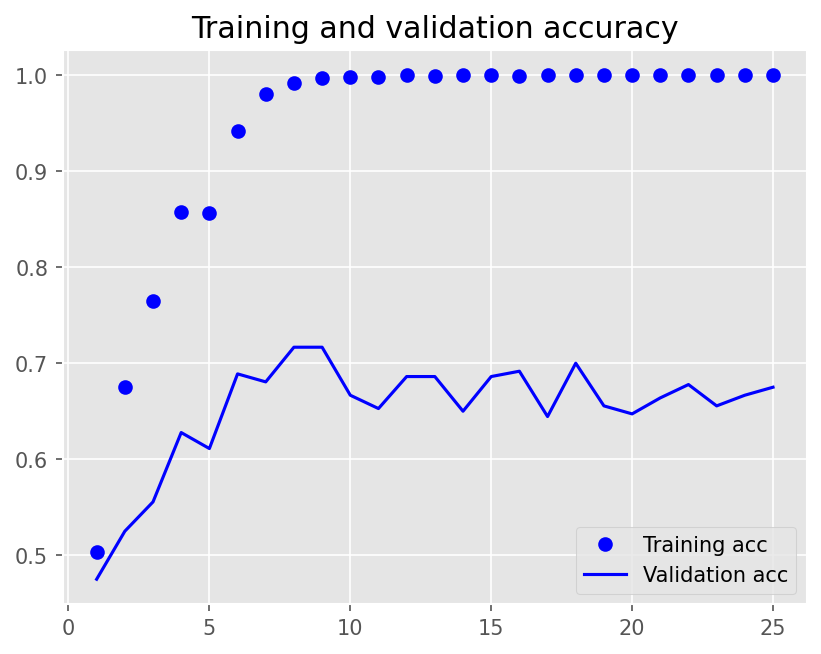

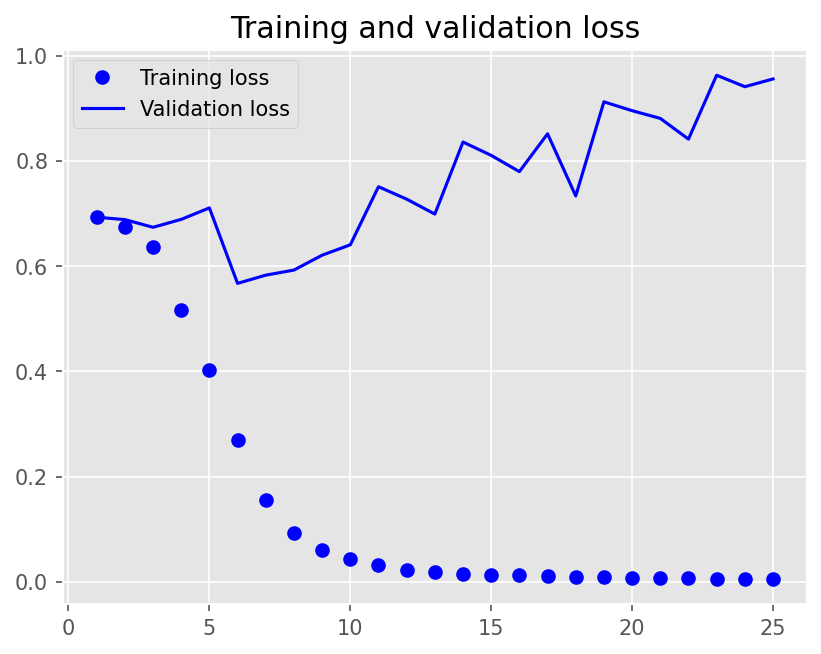

In [76]:
plot1(history5)

In [48]:
model5.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.6740 - accuracy: 0.7550 - 144ms/epoch - 72ms/step


[0.6739590167999268, 0.7549999952316284]

## Model Definition (Part 3)

- Sequence models can be further enriched by:
    - considering all the hidden states at all timesteps;
    - introducing the mechansim of **attention**.


We can make the LSTM models more powerful in at least three more ways:

1. **Add another Dense layer to the output of LSTM**: This additional dense layer can help further refine and transform the information learned by the LSTM hidden states before making final predictions.

1. **Considering all hidden states at all timesteps**: In a standard LSTM model, only the **final** hidden state is typically used for making predictions. However, by considering **all the hidden states** at each timestep, the model can capture more detailed information from the input sequence. This allows the model to better understand the temporal dynamics of the sequence and make more accurate predictions.

2. **Introducing the mechanism of attention**: Attention mechanisms allow the model to selectively focus on different parts of the input sequence when making predictions. Instead of treating all parts of the sequence equally, attention mechanisms assign different weights to each timestep's hidden state based on its relevance to the current prediction task. This allows the model to prioritize important information and ignore irrelevant or less informative parts of the sequence, leading to improved performance on tasks such as machine translation, text summarization, and sentiment analysis.


### Model 6 (LSTM + Dense)

- One Embedding Layer + LSTM [hidden state of last time step + cell state of last time step] + Dense Layer
- Inputs: Text sequences (padded)

![](../images/chris-olah/LSTM3-chain-annotated.jpeg)
(Source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.015.jpeg)

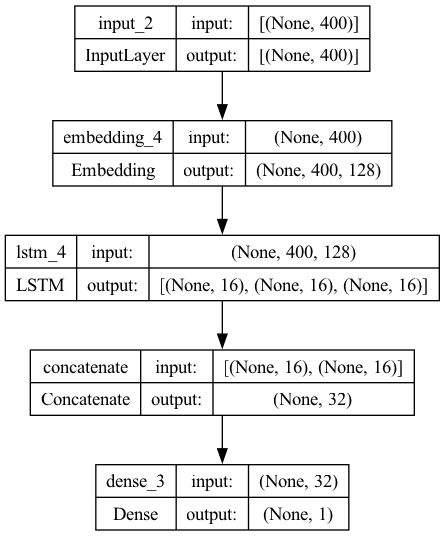

In [38]:
## Model 6

## Functional API
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
_, x_last_h, x_c = LSTM(16,
                        dropout=0.2,
                        recurrent_dropout=0.2,
                        return_sequences=False,
                        return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

x = Concatenate(axis=1)([x_last_h, x_c])
outputs = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=inputs, outputs=outputs)

plot_model(model6, show_shapes=True)

In [50]:
model6.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history6 = model6.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6921 - accuracy: 0.5326 - val_loss: 0.6908 - val_accuracy: 0.5472 - 8s/epoch - 634ms/step
Epoch 2/25
12/12 - 4s - loss: 0.6724 - accuracy: 0.7069 - val_loss: 0.6851 - val_accuracy: 0.5667 - 4s/epoch - 347ms/step
Epoch 3/25
12/12 - 4s - loss: 0.6268 - accuracy: 0.7750 - val_loss: 0.6640 - val_accuracy: 0.5778 - 4s/epoch - 354ms/step
Epoch 4/25
12/12 - 4s - loss: 0.4815 - accuracy: 0.8431 - val_loss: 0.5603 - val_accuracy: 0.7306 - 4s/epoch - 346ms/step
Epoch 5/25
12/12 - 4s - loss: 0.3212 - accuracy: 0.9097 - val_loss: 0.5372 - val_accuracy: 0.7611 - 4s/epoch - 344ms/step
Epoch 6/25
12/12 - 4s - loss: 0.2178 - accuracy: 0.9479 - val_loss: 0.5404 - val_accuracy: 0.7361 - 4s/epoch - 350ms/step
Epoch 7/25
12/12 - 4s - loss: 0.1449 - accuracy: 0.9792 - val_loss: 0.6886 - val_accuracy: 0.7444 - 4s/epoch - 356ms/step
Epoch 8/25
12/12 - 4s - loss: 0.0935 - accuracy: 0.9826 - val_loss: 0.7515 - val_accuracy: 0.7472 - 4s/epoch - 355ms/step
Epoch 9/25
12/12 - 4s - 

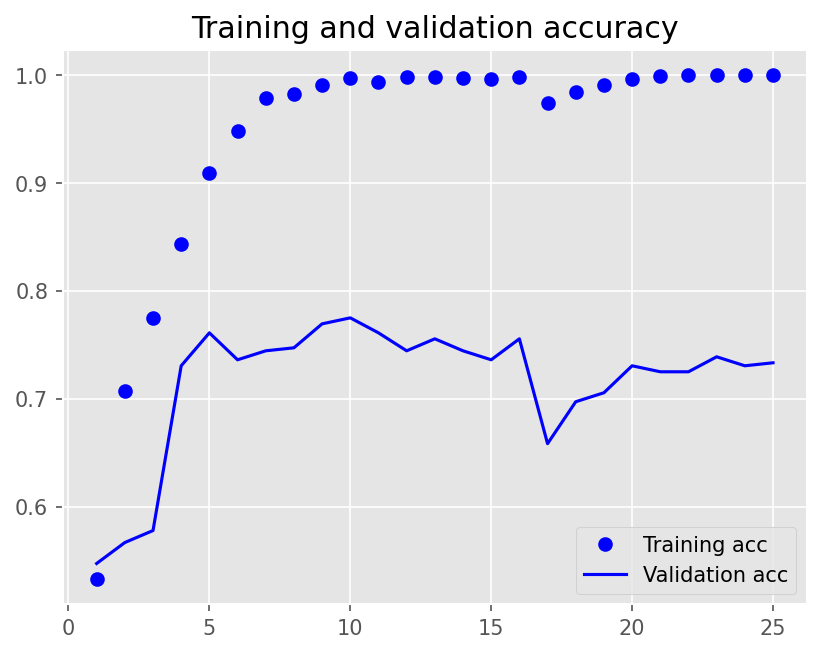

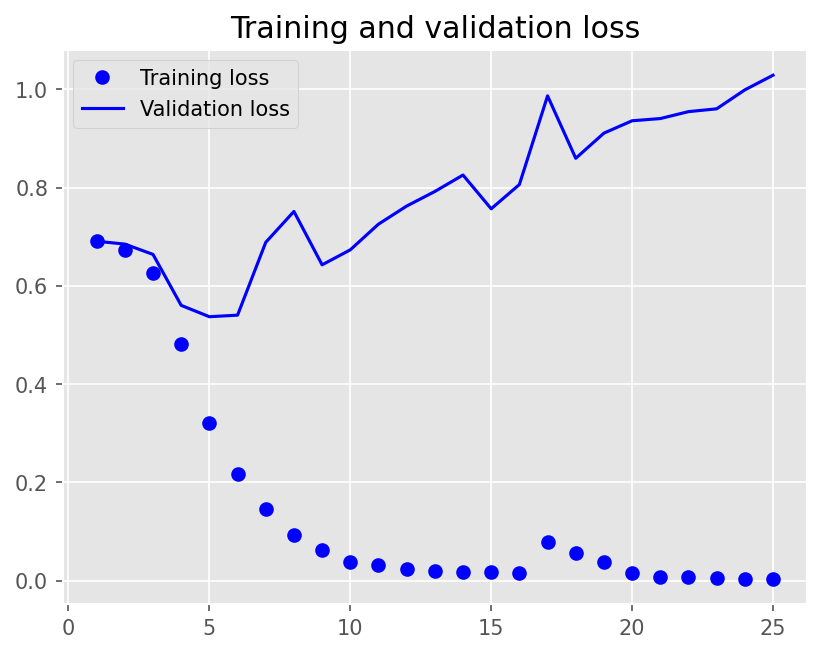

In [75]:
plot1(history6)

In [52]:
model6.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.0688 - accuracy: 0.7300 - 141ms/epoch - 71ms/step


[1.068809151649475, 0.7300000190734863]

### Model 7 (LSTM + Attention)

- Embedding + LSTM + Self-Attention + Dense
- Inputs: Text sequences

- All of the previous RNN-based models only utilize the output of the **last time step** from the RNN as the input of the decision-making Dense layer.
- We can also make **all the hidden outputs** at all time steps from the RNN available to decision-making Dense layer.
- This is the idea of **Attention**.

:::{note}
In the context of LSTM (Long Short-Term Memory) networks, the attention mechanism is a method used to enhance the model's ability to focus on specific parts of the input sequence when making predictions. 

Instead of processing the entire input sequence uniformly, the attention mechanism assigns different weights to different parts of the sequence, allowing the model to pay more attention to relevant information and ignore irrelevant or less important information. 

This is particularly useful in tasks where certain parts of the input sequence are more relevant to the prediction than others, such as machine translation or text summarization. 

By incorporating attention mechanisms into LSTM networks, the model can better capture long-range dependencies and improve its performance on sequence-related tasks.
:::

![](../images/seq2seq-self-atten.gif)

- Here we add one `Self-Attention` layer, which gives us a weighted version of all the hidden states from the RNN.
- Self Attention layer is a simple sequence-to-sequence layer, which takes in a set of input tensors and returns a set of output tensors.
- In Self Attention Layer, each output vector is transformed by considering the pairwise similarities of its corresponding input vector and all the other input vectors.
- We will come back to the Attention mechanism in the later unit for more details.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.016.jpeg)

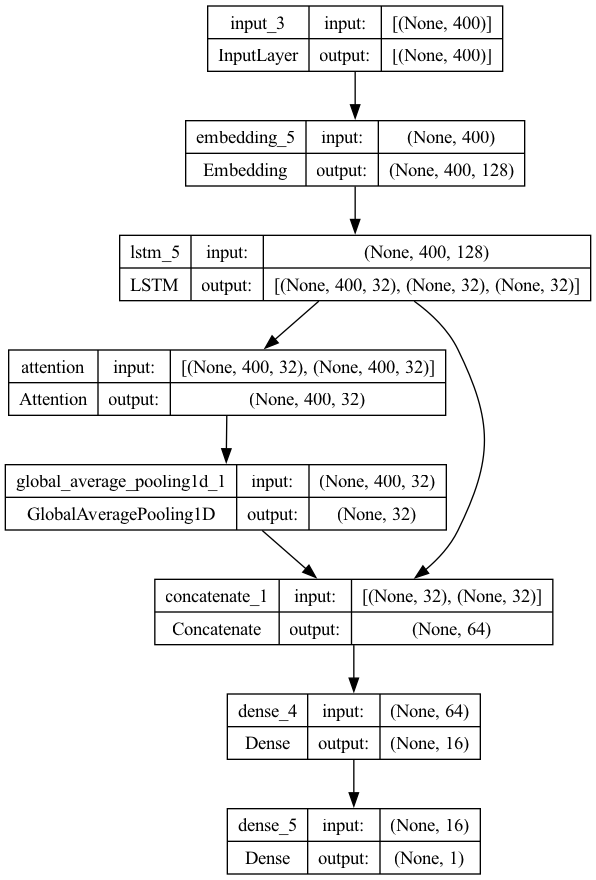

In [39]:
## Model 7 (Self-Attention)

inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
x_all_hs, x_last_h, x_last_c = LSTM(32,
                                    dropout=0.2,
                                    recurrent_dropout=0.2,
                                    return_sequences=True,
                                    return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

## Self Attention
atten_out = Attention()([x_all_hs, x_all_hs])  # query and key
atten_out_average = GlobalAveragePooling1D()(atten_out)

x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
x = Dense(16, activation="relu")(x_last_h_plus_atten)
outputs = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=inputs, outputs=outputs)

plot_model(model7, show_shapes=True)

In [54]:
# ## Model 7 (Attention of lasth on allh)

# inputs = Input(shape=(max_len,))
# x = Embedding(input_dim=vocab_size,
#               output_dim=EMBEDDING_DIM,
#               input_length=max_len,
#               mask_zero=True)(inputs)
# x_all_hs, x_last_h, x_last_c = LSTM(32,
#                                     dropout=0.2,
#                                     recurrent_dropout=0.2,
#                                     return_sequences=True,
#                                     return_state=True)(x)
# ## LSTM Parameters:
# #     `return_seqeunces=True`: return the hidden states for each time step
# #     `return_state=True`: return the cell state of the last time step
# #     When both are set True, the return values of LSTM are:
# #     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
# #     (2) the hidden state of the last time step
# #     (3) the cell state of the last time step

# ## Self Attention
# atten_out = Attention()([x_last_h, x_all_hs])  # Attention of last hidden states on all preceding states
# atten_out_average = layers.GlobalMaxPooling1D()(atten_out)

# x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
# x = Dense(16, activation="relu")(x_last_h_plus_atten)
# outputs = Dense(1, activation='sigmoid')(x)
# model7 = Model(inputs=inputs, outputs=outputs)

# plot_model(model7, show_shapes=True)

In [55]:
# ## Model 7 (Self-Attention before RNN)

# inputs = Input(shape=(max_len, ))
# x = Embedding(input_dim=vocab_size,
#               output_dim=EMBEDDING_DIM,
#               input_length=max_len,
#               mask_zero=True)(inputs)

# atten_out = Attention()([x,x])

# x_all_hs, x_last_h, x_last_c = LSTM(32,
#                                     dropout=0.2,
#                                     recurrent_dropout=0.2,
#                                     return_sequences=True,
#                                     return_state=True)(atten_out)
# ## LSTM Parameters:
# #     `return_seqeunces=True`: return the hidden states for each time step
# #     `return_state=True`: return the cell state of the last time step
# #     When both are set True, the return values of LSTM are:
# #     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
# #     (2) the hidden state of the last time step
# #     (3) the cell state of the last time step

# x = Dense(16, activation="relu")(x_last_h)
# outputs = Dense(1, activation='sigmoid')(x)
# model7 = Model(inputs=inputs, outputs=outputs)

# plot_model(model7, show_shapes=True)

In [56]:
model7.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history7 = model7.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 12s - loss: 0.6925 - accuracy: 0.5243 - val_loss: 0.6929 - val_accuracy: 0.4833 - 12s/epoch - 1s/step
Epoch 2/25
12/12 - 8s - loss: 0.6809 - accuracy: 0.7174 - val_loss: 0.6812 - val_accuracy: 0.6278 - 8s/epoch - 672ms/step
Epoch 3/25
12/12 - 8s - loss: 0.6183 - accuracy: 0.8222 - val_loss: 0.5941 - val_accuracy: 0.7111 - 8s/epoch - 677ms/step
Epoch 4/25
12/12 - 8s - loss: 0.3753 - accuracy: 0.8681 - val_loss: 0.4825 - val_accuracy: 0.7778 - 8s/epoch - 678ms/step
Epoch 5/25
12/12 - 8s - loss: 0.2170 - accuracy: 0.9618 - val_loss: 0.6088 - val_accuracy: 0.7556 - 8s/epoch - 672ms/step
Epoch 6/25
12/12 - 8s - loss: 0.0985 - accuracy: 0.9694 - val_loss: 0.4559 - val_accuracy: 0.8139 - 8s/epoch - 665ms/step
Epoch 7/25
12/12 - 8s - loss: 0.0429 - accuracy: 0.9910 - val_loss: 0.6644 - val_accuracy: 0.7944 - 8s/epoch - 676ms/step
Epoch 8/25
12/12 - 8s - loss: 0.0181 - accuracy: 0.9958 - val_loss: 0.8001 - val_accuracy: 0.7806 - 8s/epoch - 671ms/step
Epoch 9/25
12/12 - 8s - l

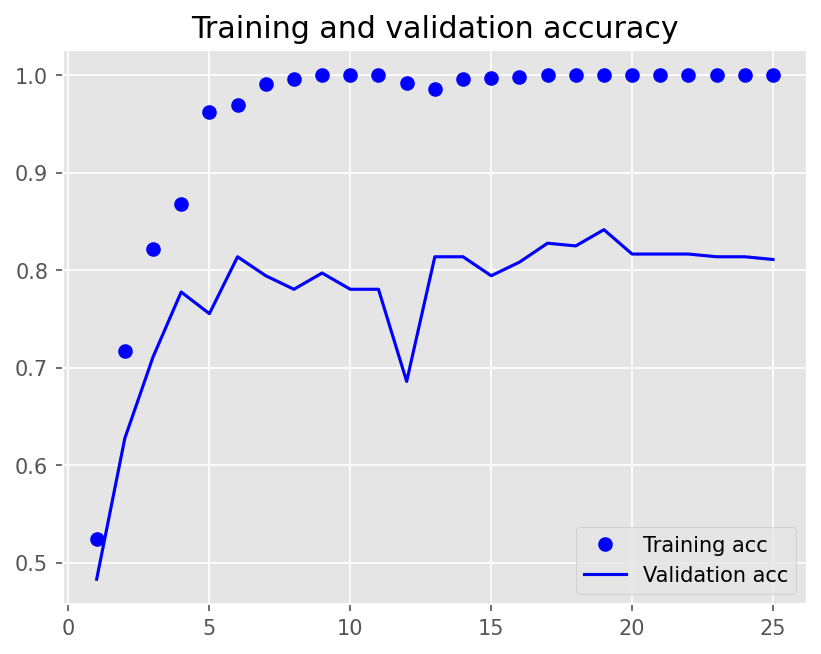

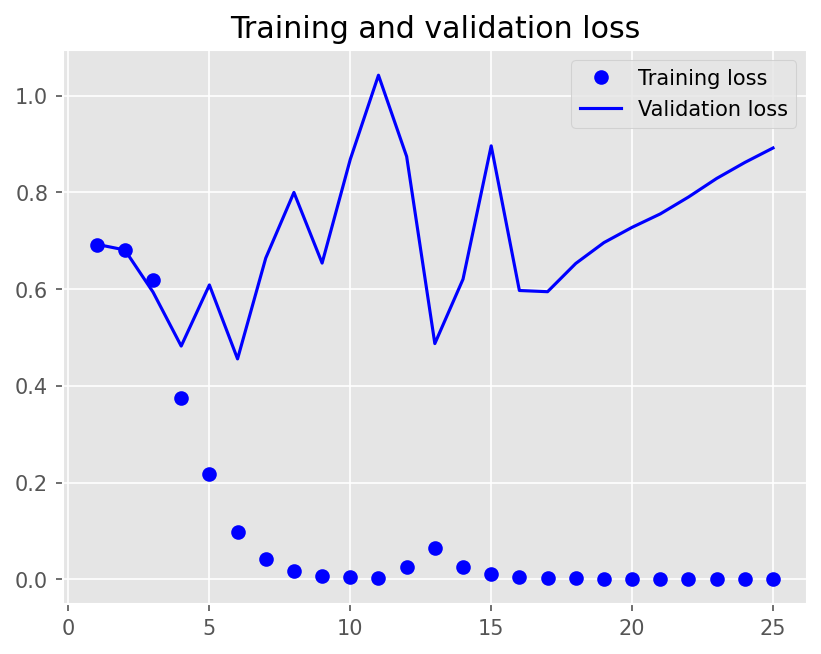

In [74]:
plot1(history7)

In [58]:
model7.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.8629 - accuracy: 0.8300 - 366ms/epoch - 183ms/step


[0.8629053235054016, 0.8299999833106995]

## Explanation

- We use LIME for model explanation.
- Let's inspect the Attention-based Model (model7).

:::{warning}
In our current experiments, we have not considered very carefully the issue of model over-fitting. To optimize the network, it is necessary to include **regularization** and **dropouts** to reduce the variation of the model performance on unseen datasets (i.e., **generalization**).
:::

In [59]:
## Colab only
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=1e956a27b9916a111673baaeafca666d2cf4ecea283261cf06c8f0ea2f413425
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [60]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'],
                              char_level=False)

## Select the best model so far
best_model = model7

In [61]:
## Pipeline for LIME
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    return np.array([[float(1 - x), float(x)]
                     for x in best_model.predict(np.array(_seq_pad))])

In [62]:
text_id = 3
exp = explainer.explain_instance(X_test_texts[text_id],
                                 model_predict_pipeline,
                                 num_features=20,
                                 top_labels=1)
exp.show_in_notebook(text=True)

157/157 [==============================] - 10s 62ms/step


<ipython-input-61-a1a375469bbb>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([[float(1 - x), float(x)]


In [63]:
exp.show_in_notebook(text=True)

## Check Embeddings

- We can also examine the word embeddings learned along with our Classifier.
- Steps include:
    - Extract the embedding weights from the trained model.
    - Determine words we would like to inspect.
    - Extract the embeddings of these words.
    - Use dimensional reduction techniques to plot word embeddings in a 2D graph.

In [64]:
word_vectors = best_model.layers[1].get_weights()[0]
word_vectors.shape

(10001, 128)

In [65]:
## Mapping of embeddings and word-labels
token_labels = [
    word for (ind, word) in tokenizer.index_word.items()
    if ind < word_vectors.shape[0]
]
token_labels.insert(0, "PAD")
token_labels[:10]

['PAD', 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

In [66]:
len(token_labels)

10001

- Because there are many words, we select words for visualization based on the following criteria:
    - Include embeddings of words that are not on the English stopword list (`nltk.corpus.stopwords.words('english')`) and whose word length >= 5 (characters)

In [67]:
from sklearn.manifold import TSNE
stopword_list = nltk.corpus.stopwords.words('english')

In [68]:
out_index = [
    i for i, w in enumerate(token_labels)
    if len(w) >= 5 and w not in stopword_list
]
len(out_index)

8195

In [69]:
out_index[:10]

[27, 69, 70, 73, 80, 83, 95, 97, 100, 102]

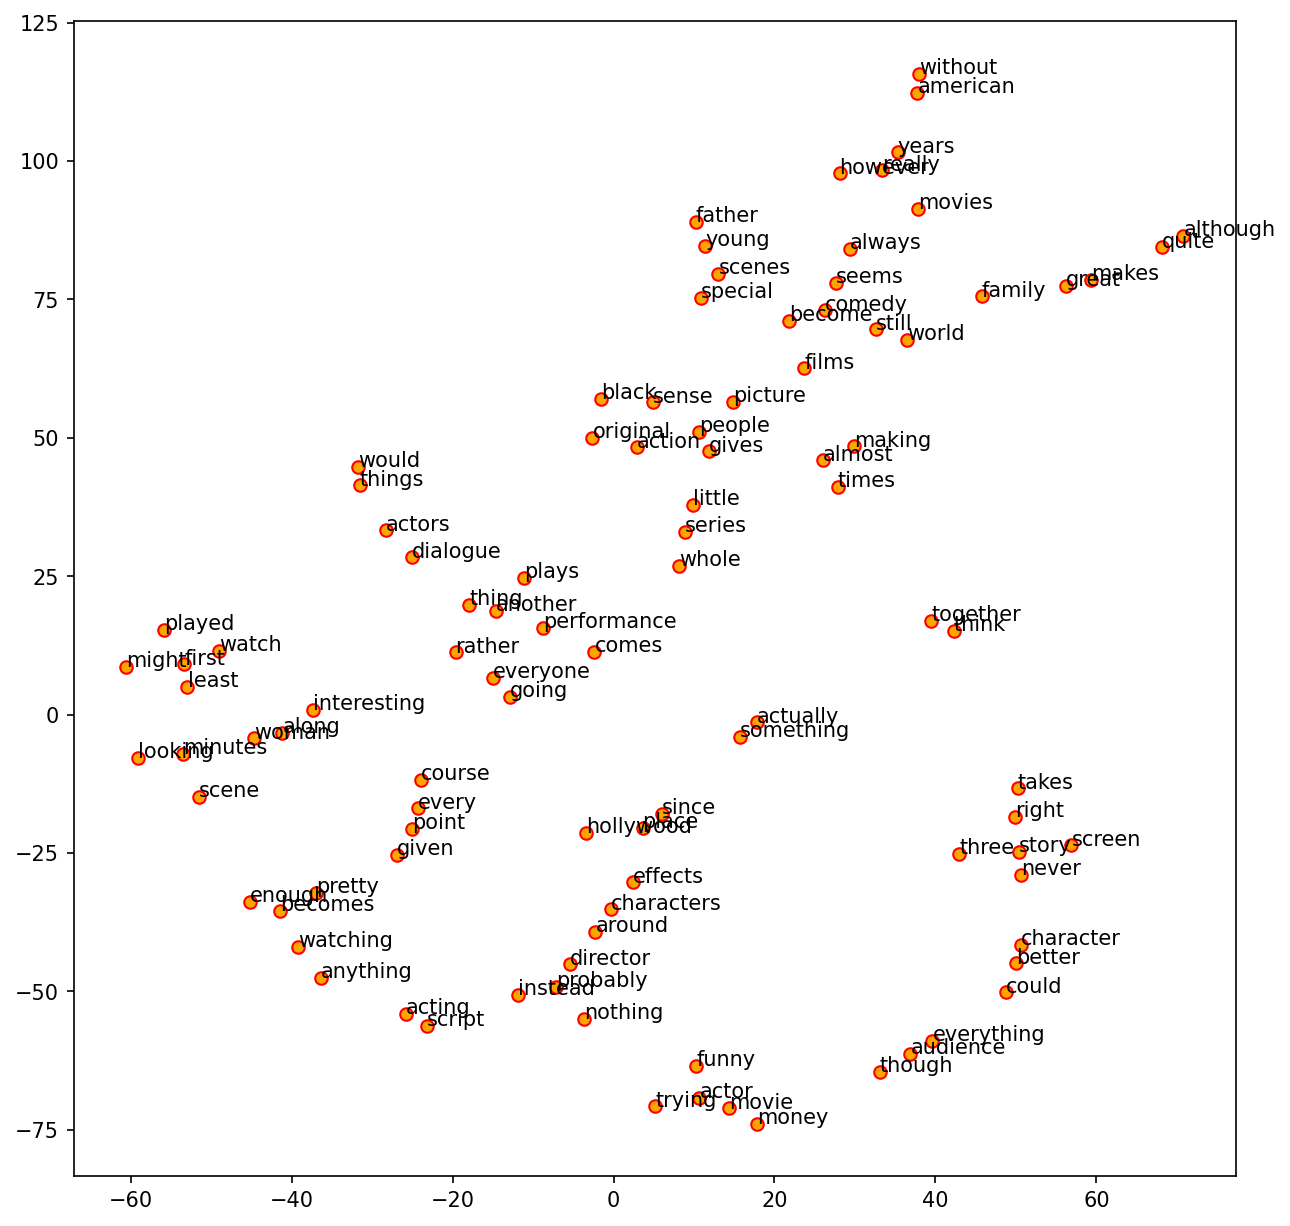

In [70]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[out_index[:100], ])
labels = list(np.array(token_labels)[out_index[:100]])

len(labels)

plt.figure(figsize=(10, 10), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 0.01, y + 0.01),
                 xytext=(0, 0),
                 textcoords='offset points')

## Model Comparisons

- Let's compare the learning performance of all the models by examining their changes of accuracies and losses in each epoch of training.

In [71]:
history = [
    history1, history2, history3, history4, history5, history6, history7
]
history = [i.history for i in history]
model_names = [
    'One-hot-dense', 'Embedding-dense', 'RNN', 'Two-RNN', 'Bidirect',
    'Hidden-Cell', 'Self-attention'
]

## Set color pallete
import seaborn as sns
qualitative_colors = sns.color_palette("Paired", len(history))

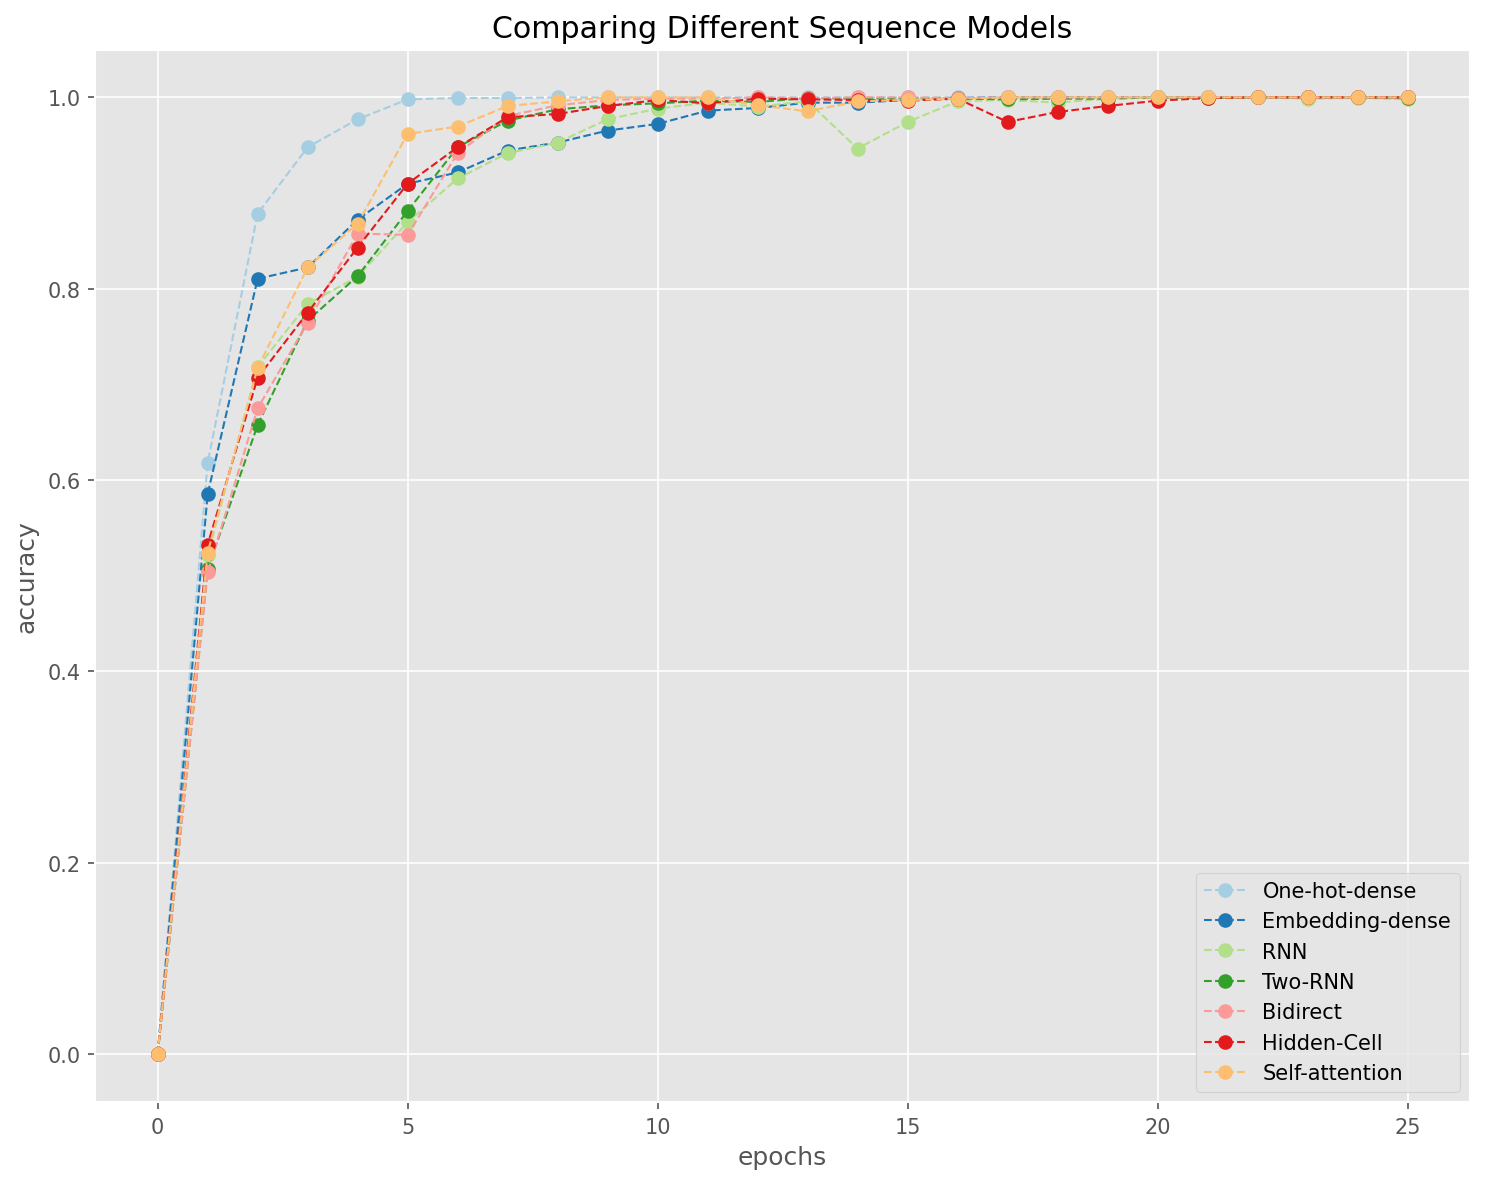

In [72]:
## Accuracy
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

- General Observations
    - Fully-connected network works better with one-hot encoding of texts (i.e., bag-of-words vectorized representations of texts)
    - Embeddings are more useful when working with sequence models (e.g., RNN).
    - The self-attention layer, in our current case, is on the entire input sequence, and therefore is limited in its effects.

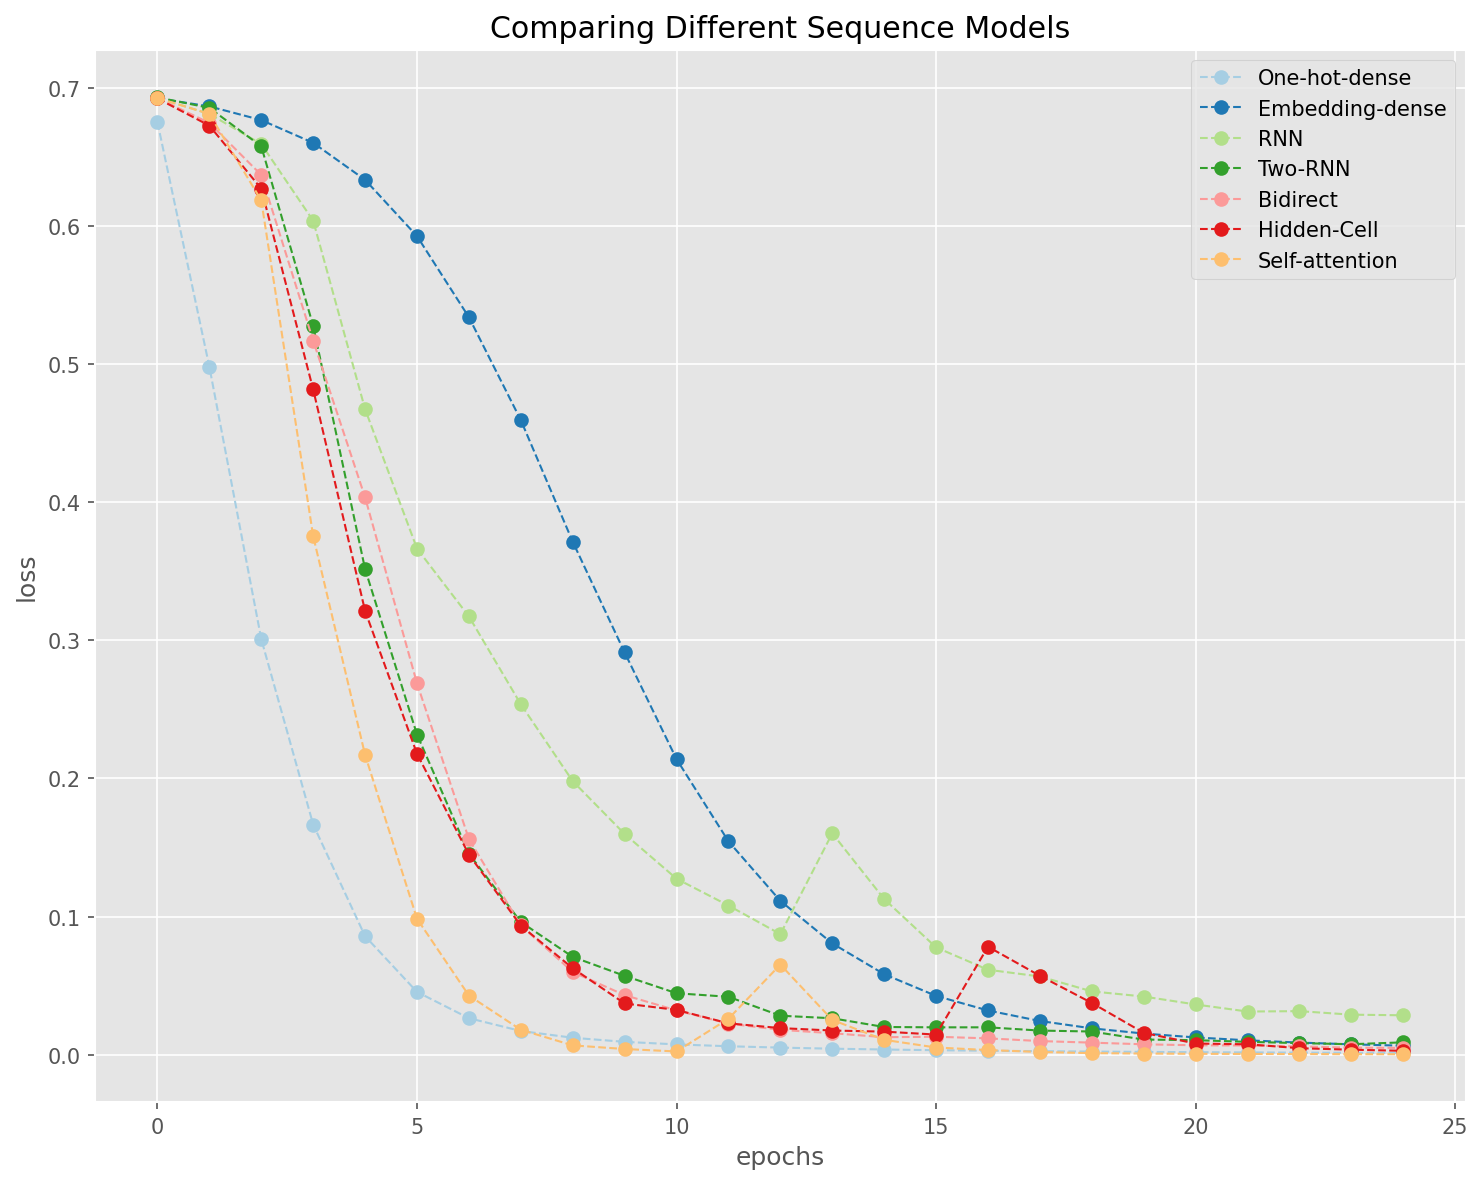

In [73]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()